In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,dt_runs,name,class,dataset,type,Label
0,0.369422,0.078324,0.000444,0.009978,0.724212,0.007168,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.453125,0.025104,0.000232,0.009977,0.045600,0.005091,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,0.343750,0.000896,0.000248,0.009981,0.009991,0.007399,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,0.328125,0.008395,0.000234,0.009978,0.047617,0.000714,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.375000,0.038187,0.000241,0.009978,0.036785,0.003844,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...
1735835,0.187500,0.000000,0.000248,0.020620,0.020620,0.000941,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735836,0.265625,0.000000,0.000235,0.013305,0.013305,0.013305,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735837,0.312500,0.000000,0.000242,0.013092,0.013092,0.013092,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735838,0.265625,0.000000,0.000435,0.012329,0.012329,0.001398,FreeDrivingData_20171231_Spark,Spark,Survival,none,0


In [3]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [4]:
col = "dcs"
v_r         = df.loc[(df["Label"] == 0) & (df["dataset"] == "ROAD"), col]
v_sonata    = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Sonata"), col]
v_soul      = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Soul"), col]
v_spark     = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Spark"), col]

print(v_r.mean(), v_r.std())
print(v_sonata.mean(), v_sonata.std())
print(v_soul.mean(), v_soul.std())
print(v_spark.mean(), v_spark.std())

nan nan
0.34148075670757533 0.12608906542014023
0.3736639272696253 0.1237635679917148
0.309531191803434 0.15327664060840848


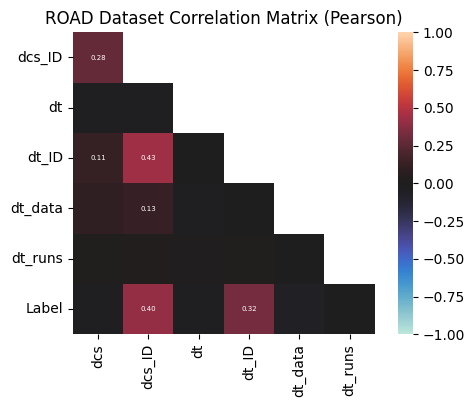

In [5]:
from plot_tools import plot_correlation_matrix

plot_correlation_matrix(df.drop(columns=["dataset", "type", "name", "class" "ID", "DLC", "t"], errors="ignore"))

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler

for col in ["dcs", "dcs_ID", "dt", "dt_ID", "dt_data", "dt_runs"]:
    scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
    df.loc[:, df.columns ==col] = scaler.transform(df.loc[:, df.columns == col])

# display(df)

In [7]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [8]:
# X_train = df.loc[df["type"] != "normal"]
# y_train = X_train["Label"]
# X_train = X_train.drop(columns="Label")

# X_test = df.loc[df["type"] == "normal"]
# y_test = X_test["Label"]
# X_test = X_test.drop(columns="Label")

In [9]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		128216		55098
Attack		128216		55098


In [10]:
# train_index = X_train.loc[X_train["dataset"] == "Survival"].index
# test_index = X_test.loc[X_test["dataset"] == "ROAD"].index
# train_index = X_train.loc[(X_train["dataset"] == "Survival") & (X_train["name"] == "Fuzzy_dataset_SONATA")].index
# test_index = X_test.loc[(X_test["dataset"] == "ROAD") & (X_test["name"] == "fuzzing_attack_1")].index

# X_train = X_train.loc[train_index]
# y_train = y_train.loc[train_index]

# X_test = X_test.loc[test_index]
# y_test = y_test.loc[test_index]

In [11]:
# name_train = X_train["name"]
# name_test = X_test["name"]
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2", warm_start=True)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', max_leaf_nodes=300, n_estimators=20,
                       random_state=0, warm_start=True)

In [13]:
# pred_train = clf.predict(X_train)
# clf.set_params(n_estimators=(20+13)) # Add another tree for the FN and FPs
# clf.fit(X_train.loc[y_train != pred_train], y_train.loc[y_train != pred_train])

In [14]:
scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

pred = clf.predict(X_test)

f1_scores = f1_score(y_test, pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1: 0.9993 (+/- 0.0001)
Testing F1:  0.9994(+/- 0.0000)
Kappa score:  0.9988(+/- 0.0000)


Plot train then test data predictions

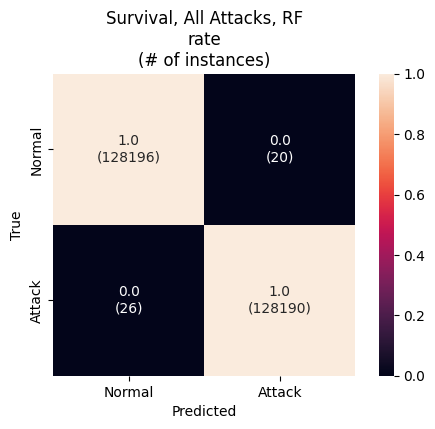

In [15]:
from plot_tools import plot_confusion_matrix

pred_train = clf.predict(X_train)

plot_confusion_matrix(y_train, pred_train, "Survival, All Attacks, RF\nrate\n(# of instances)")

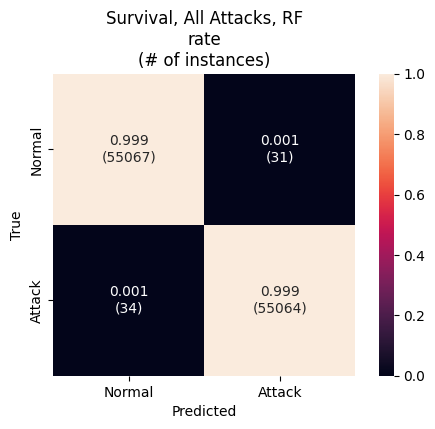

In [16]:
plot_confusion_matrix(y_test, pred, "Survival, All Attacks, RF\nrate\n(# of instances)")

In [17]:
import shap

exp = shap.TreeExplainer(clf)

In [20]:
from shap_tools import *


# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
assert np.abs(exp.model.predict(X_train) - clf.predict_proba(X_train)).max() < 1e-4

shap_all = get_explanation(exp, X_train)

# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs((shap_all.base_values + shap_all.values).sum(1) - clf.predict_proba(X_train)).max() < 1e-4

# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

# shap_TP_fuzz = get_explanation(exp, X_test.loc[(y_train == pred) & (pred == 1) & (name_test == "Fuzzy_dataset_SONATA")])

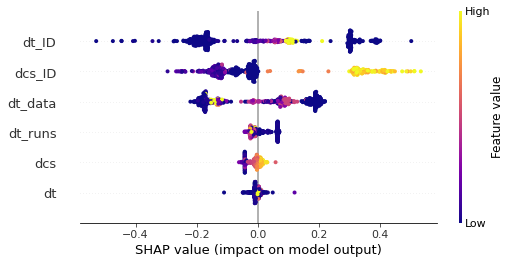

In [21]:
plot_beeswarm(shap_all)

In [22]:
plot_force(shap_all)

In [19]:
from sklearn.metrics import confusion_matrix
pred_train = clf.predict(X_train)
cm = confusion_matrix(y_train, pred_train)

result = [[cm[0][1]], [cm[1][0]]]

for i in range(1, 31):
    clf.set_params(n_estimators=(20+i)) # Add another tree for the FN and FPs
    clf.fit(X_train.loc[y_train != pred_train], y_train.loc[y_train != pred_train]) # 1 for FP, 0 for FN
    pred_train = clf.predict(X_train)
    cm = confusion_matrix(y_train, pred_train)
    result[0].append(cm[0][1])
    result[1].append(cm[1][0])

print(result[0])
print(result[1])

[20, 21, 18, 18, 15, 15, 11, 13, 11, 18, 10, 10, 7, 10, 6, 6, 4, 6, 5, 8, 1139, 9, 6324, 8, 8741, 6, 8743, 5, 8749, 4, 8745]
[26, 28, 23, 22, 17, 19, 19, 18, 15, 15, 11, 11, 8, 10, 6, 13, 9, 8, 12, 8, 136, 5, 121, 7, 123, 5, 120, 7, 5, 5, 141]


<function matplotlib.pyplot.show(close=None, block=None)>

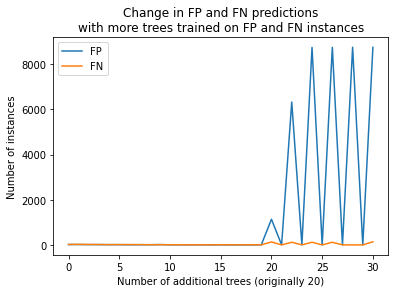

In [20]:
plt.plot(result[0], label="FP")
plt.plot(result[1], label="FN")
plt.title("Change in FP and FN predictions\nwith more trees trained on FP and FN instances")
plt.xlabel("Number of additional trees (originally 20)")
plt.ylabel("Number of instances")
plt.legend()
plt.show